# MLP Method

In [1]:
import pickle
from glob import glob
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import time
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
train_path = "processed_training.npz"
train_data = np.load(train_path)
#test_path = "processed_testing.npz"
#test_data = np.load(test_path)

In [3]:
class MLPNet(nn.Module):
    def __init__(self, 
                 in_dim, # input dimension
                 out_dim, # output dimension
                 hidden_dim, # hidden dimension
                 num_layers # number of layers
                ):
        
        super(MLPNet, self).__init__()
        
        self.model = [nn.Linear(in_dim, hidden_dim), nn.ReLU()]
        
        for i in range(num_layers-2):
            self.model += [nn.Linear(hidden_dim, hidden_dim), nn.ReLU()]
        
        self.model += [nn.Linear(hidden_dim, out_dim)]
        
        self.model = nn.Sequential(*self.model)
        
    def forward(self, inp):
        
        # Flatten the last two dimensions
        inp = inp.reshape(inp.shape[0], -1)
        
        out = self.model(inp)
        
        #bz x outputlength x 2
        return out.reshape(inp.shape[0], -1)

In [4]:
batch_size = 512
in_dim = 19*4
out_dim = 30*2
hidden_dim = 128
num_layers = 3
learning_rate = 0.01
decay_rate = 0.95
num_epoch = 1000

In [5]:
# RNN, LSTM, 1dCNN, Transformer
model = MLPNet(in_dim = in_dim, 
               out_dim = out_dim,
               hidden_dim = hidden_dim, 
               num_layers = num_layers).to(device) # move model to gpu 

# Adaptive Moment Estimation computes adaptive learning rates for each parameter. 
# Compute the decaying averages of past and past squared gradients. 

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=decay_rate)  # stepwise learning rate decay
loss_fun = nn.MSELoss()

In [6]:
def train_epoch(model, optimizer, loss_function):
    train_mse = []
    idx = np.random.permutation(batch_size * 370).reshape(370, batch_size)
    for i in idx:
        inp = torch.from_numpy(train_data["X"][i]).float().to(device)
        tgt = torch.from_numpy(train_data["y"][i]).float().to(device)
        pred = model(inp)
        loss = loss_function(pred, tgt)
        train_mse.append(loss.item()) 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_mse = round(np.sqrt(np.mean(train_mse)),5)
    return train_mse

def eval_epoch(model, loss_function):
    valid_mse = []
    preds = []
    trues = []
    with torch.no_grad():
        idx = np.random.permutation(range(batch_size * 370, batch_size * 402)).reshape(32, batch_size)
        for i in idx:
            inp = torch.from_numpy(train_data["X"][i]).float().to(device)
            tgt = torch.from_numpy(train_data["y"][i]).float().to(device)
            pred = model(inp)
            loss = loss_function(pred, tgt)
            preds.append(pred.cpu().data.numpy())
            trues.append(tgt.cpu().data.numpy())
            valid_mse.append(loss.item())
            
        preds = np.concatenate(preds, axis = 0)  
        trues = np.concatenate(trues, axis = 0)  
        valid_mse = round(np.sqrt(np.mean(valid_mse)), 5)
    return valid_mse, preds, trues


In [7]:
train_rmse = []
valid_rmse = []
min_rmse = 10e8

for i in range(num_epoch):
    start = time.time()

    # model.train() # if you use dropout or batchnorm. 
    train_rmse.append(train_epoch(model, optimizer, loss_fun))

    # model.eval()
    val_rmse, val_preds, val_trues = eval_epoch(model, loss_fun)
    valid_rmse.append(val_rmse)

    # save the best model
    if valid_rmse[-1] < min_rmse:
        min_rmse = valid_rmse[-1] 
        best_model = model
        # torch.save([best_model, i, get_lr(optimizer)], name + ".pth")

    end = time.time()
    
    # Early Stopping
    if (len(train_rmse) > 100 and np.mean(valid_rmse[-5:]) >= np.mean(valid_rmse[-10:-5])):
            break       

    # Learning Rate Decay        
    scheduler.step()
    
    print("Epoch {} | T: {:0.2f} | Train RMSE: {:0.5f} | Valid RMSE: {:0.5f}".format(i + 1, (end-start) / 60, train_rmse[-1], valid_rmse[-1]))

Epoch 1 | T: 1.82 | Train RMSE: 0.08458 | Valid RMSE: 0.03725
Epoch 2 | T: 1.81 | Train RMSE: 0.02301 | Valid RMSE: 0.02064
Epoch 3 | T: 1.82 | Train RMSE: 0.02036 | Valid RMSE: 0.01612
Epoch 4 | T: 1.82 | Train RMSE: 0.01930 | Valid RMSE: 0.01640
Epoch 5 | T: 1.80 | Train RMSE: 0.01845 | Valid RMSE: 0.01493
Epoch 6 | T: 1.80 | Train RMSE: 0.01825 | Valid RMSE: 0.01493
Epoch 7 | T: 1.80 | Train RMSE: 0.01680 | Valid RMSE: 0.01740
Epoch 8 | T: 1.80 | Train RMSE: 0.01677 | Valid RMSE: 0.02064
Epoch 9 | T: 1.80 | Train RMSE: 0.01627 | Valid RMSE: 0.02941
Epoch 10 | T: 1.80 | Train RMSE: 0.01514 | Valid RMSE: 0.01196
Epoch 11 | T: 1.81 | Train RMSE: 0.01498 | Valid RMSE: 0.01181
Epoch 12 | T: 1.80 | Train RMSE: 0.01475 | Valid RMSE: 0.01197
Epoch 13 | T: 1.82 | Train RMSE: 0.01449 | Valid RMSE: 0.01090
Epoch 14 | T: 1.81 | Train RMSE: 0.01331 | Valid RMSE: 0.01482
Epoch 15 | T: 1.81 | Train RMSE: 0.01269 | Valid RMSE: 0.00948
Epoch 16 | T: 1.81 | Train RMSE: 0.01233 | Valid RMSE: 0.01149
E

In [8]:
test_path = "./val_in/"
test_pkl_list = glob(os.path.join(test_path, '*'))
test_pkl_list.sort()

test_preds = []
for idx in range(len(test_pkl_list)):
    with open(test_pkl_list[idx], 'rb') as f:
        test_sample = pickle.load(f)
        pred_id = np.where(test_sample["track_id"] == test_sample['agent_id'])[0][0]
        inp_scene = np.dstack([test_sample['p_in'], test_sample['v_in']])

        # Normalization 
        min_vecs = np.min(inp_scene, axis = (0,1))
        max_vecs = np.max(inp_scene, axis = (0,1))
        
        inp = (inp_scene[pred_id] - min_vecs)/(max_vecs - min_vecs)
        
        inp = torch.from_numpy(inp).float().to(device).unsqueeze(0)

        preds = best_model(inp).cpu().data.numpy()
        preds = preds.reshape(30, 2)
        
        # De-Normalization !
        preds = preds * (max_vecs[:2] - min_vecs[:2]) +  min_vecs[:2]
        test_preds.append(preds)

In [9]:
# Convert to int
sample_sub = pd.read_csv('sample_submission.csv')
predictions = np.concatenate(test_preds).reshape(len(test_preds), -1).astype(int)
sub_df = pd.DataFrame(np.c_[sample_sub["ID"], predictions], columns=[np.r_[["ID"], ["v" + str(i) for i in range(1, 61)]]])
sub_df.to_csv('test_submission.csv', index=None)

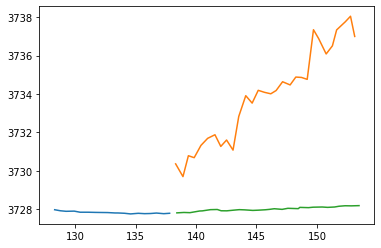

In [14]:
from matplotlib import pyplot as plt
test_path = "./train/"
test_pkl_list = glob(os.path.join(test_path, '*'))
test_pkl_list.sort()

for idx in [3]:
    with open(test_pkl_list[idx], 'rb') as f:
        test_sample = pickle.load(f)
        pred_id = np.where(test_sample["track_id"] == test_sample['agent_id'])[0][0]
        inp_scene = np.dstack([test_sample['p_in'], test_sample['v_in']])

        # Normalization 
        min_vecs = np.min(inp_scene, axis = (0,1))
        max_vecs = np.max(inp_scene, axis = (0,1))
        
        inp = (inp_scene[pred_id] - min_vecs)/(max_vecs - min_vecs)
        
        inp = torch.from_numpy(inp).float().to(device).unsqueeze(0)

        preds = best_model(inp).cpu().data.numpy()
        preds = preds.reshape(30, 2)
        
        # De-Normalization !
        preds = preds * (max_vecs[:2] - min_vecs[:2]) +  min_vecs[:2]
        inp = inp.cpu().reshape(19, 4)[:, :2] * (max_vecs[:2] - min_vecs[:2]) +  min_vecs[:2]
        

plt.plot(inp[:, 0], inp[:, 1])
plt.plot(preds[:, 0], preds[:, 1])
plt.plot(test_sample["p_out"][pred_id, :, 0], test_sample["p_out"][pred_id, :, 1])

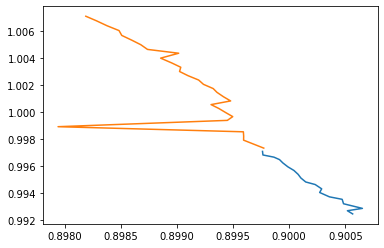

In [11]:
aa = train_data["X"][4].reshape(19, 4)
bb = train_data["y"][4].reshape(30, 2)
plt.plot(aa[:, 0], aa[:, 1])
plt.plot(bb[:, 0], bb[:, 1])